# Automatic Run with NEXT

This Notebook uses a pre-trained coefficient estimator to automatically generate temperature estimates for a given watershed.  Right now, the location has to be a USGS gage, but it doesn't have to have stream temperature.  A pre-processed geopackage of watershed boundaries (e.g., a nextgen hydrofabric subset) can also be used.

In [3]:
from NEXT import NEXT, full_data, all_data_gpkg
import matplotlib.pyplot as plt

ImportError: cannot import name 'all_data_gpkg' from 'NEXT' (C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\next\src\NEXT\__init__.py)

In [ ]:
nx = NEXT.from_pickle("coefs.pickle")

# USGS Version

In [1]:
# site = "10343500"  # Sagehen
# site = "06719505"  # Clear Creek (Q, no T)
# name = "Clear Creek at Golden, CO"
site = "02465000"  # Black Warrior R. (Q, no T) (National Water Center)
name = "Black Warrior River near Tuscaloosa, AL"

In [4]:
ws_data = full_data(site, "2010", "2022")
ws_data

C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


,id,id_type,lat,lon,area,water,developed,barren,forest,shrubland,...,unknown,ice_snow,elev,slope,elev_min,date,tmax,prcp,srad,vp
0,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.0,0.0,188.405624,0.002574,43.041714,2010-01-01,7.089761,0.010873,180.835617,621.150024
1,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.0,0.0,188.405624,0.002574,43.041714,2010-01-02,1.909065,0.000000,189.562302,415.499481
2,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.0,0.0,188.405624,0.002574,43.041714,2010-01-03,1.345206,0.000000,217.228577,363.898529
3,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.0,0.0,188.405624,0.002574,43.041714,2010-01-04,-2.179767,0.000000,151.570007,346.044830
4,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.0,0.0,188.405624,0.002574,43.041714,2010-01-05,0.378965,0.000000,268.539215,271.991058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4740,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.0,0.0,188.405624,0.002574,43.041714,2022-12-27,11.282182,0.000000,320.892334,419.339172
4741,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.0,0.0,188.405624,0.002574,43.041714,2022-12-28,16.495136,0.000000,330.406036,456.788788
4742,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.0,0.0,188.405624,0.002574,43.041714,2022-12-29,21.284662,0.000000,307.687958,848.414734
4743,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.0,0.0,188.405624,0.002574,43.041714,2022-12-30,17.771713,8.252465,160.454010,1193.256226


In [5]:
nx.make_newt(ws_data)

In [6]:
nx.make_config(f"autoconf_{site}.yaml")

In [7]:
res = nx.run(ws_data)
res

,id,id_type,lat,lon,area,water,developed,barren,forest,shrubland,...,slope,elev_min,date,tmax,prcp,srad,vp,actemp,anom,temp.mod
0,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.002574,43.041714,2010-01-01,7.089761,0.010873,180.835617,621.150024,10.368633,-0.048611,10.320022
1,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.002574,43.041714,2010-01-02,1.909065,0.000000,189.562302,415.499481,10.328932,-0.160985,10.167947
2,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.002574,43.041714,2010-01-03,1.345206,0.000000,217.228577,363.898529,10.292191,-0.341150,9.951041
3,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.002574,43.041714,2010-01-04,-2.179767,0.000000,151.570007,346.044830,10.258406,-0.876070,9.382336
4,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.002574,43.041714,2010-01-05,0.378965,0.000000,268.539215,271.991058,10.227572,-1.810831,8.416741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4740,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.002574,43.041714,2022-12-27,11.282182,0.000000,320.892334,419.339172,11.380382,-2.858027,8.522355
4741,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.002574,43.041714,2022-12-28,16.495136,0.000000,330.406036,456.788788,11.299487,-1.637556,9.661931
4742,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.002574,43.041714,2022-12-29,21.284662,0.000000,307.687958,848.414734,11.220961,-0.429071,10.791890
4743,02465000,usgs,33.209285,-87.590007,1.166748e+10,0.017467,0.116393,0.006933,0.68262,0.001708,...,0.002574,43.041714,2022-12-30,17.771713,8.252465,160.454010,1193.256226,11.144827,0.763065,11.907892


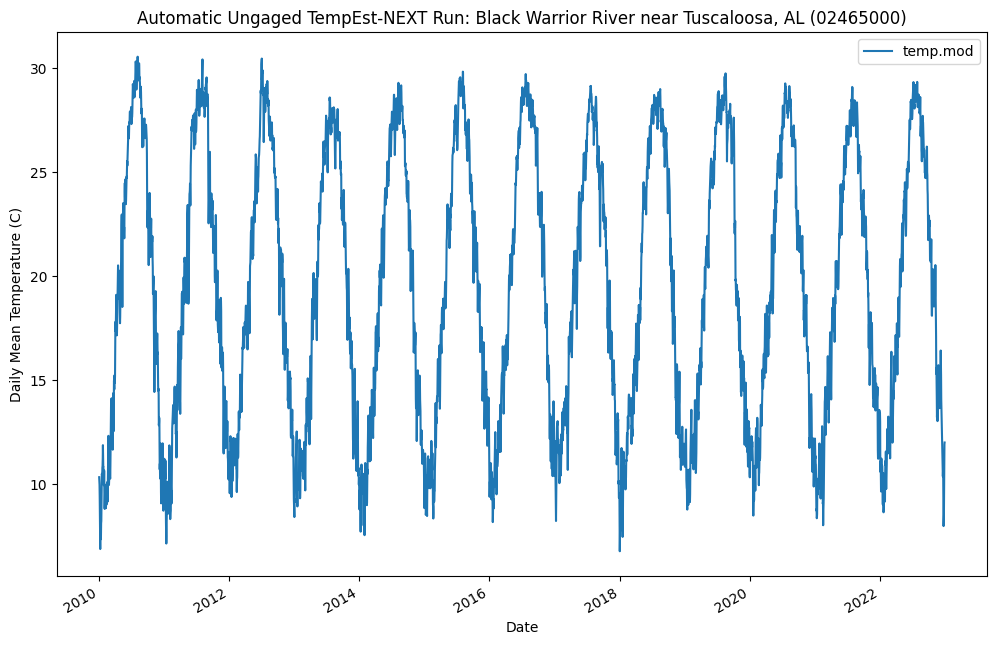

In [8]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
res.plot(x="date", y="temp.mod", ax=ax, title=f"Automatic Ungaged TempEst-NEXT Run: {name} ({site})",
        xlabel="Date", ylabel="Daily Mean Temperature (C)")
plt.savefig(f"UngagedAuto_{site}.png", dpi=1200, bbox_inches="tight")

# Geopackage Version

In [ ]:
gpkg_path = "clear_ck.geojson"
out_root = "newtconf"

In [ ]:
data_gen = all_data_gpkg(gpkg_path, "2015-01-01", "2019-12-31")

In [ ]:
for (site, data) in data_gen:
    nx.make_newt(data).make_config(f"{out_root}/{site}.yaml")